In [ ]:
!pip install -q pytorch-lightning nltk

!gdown 1PD09daNrz8lLm9W5NPVtlLzVnuryN-n4
!unzip data.zip

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip /content/glove.6B.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 33.2 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1PD09daNrz8lLm9W5NPVtlLzVnuryN-n4
To: /content/data.zip
100% 27.0M/27.0M [00:00<00:00, 62.9MB/s]
Archive:  data.zip
  inflating: IMDB Dataset.csv        
--2023-12-07 02:09:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-07 02:09:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-0

In [ ]:
import pandas as pd
import tqdm
import nltk
import regex as re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
import numpy as np
import torch
import torchmetrics
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Read file

In [ ]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Preprocessing text in the dataset

In [ ]:
# Split when face string like: \n\n---\n\n
T = df['review'].str.split(' \n\n---\n\n').str[0]


# Remove special characters like '-', not character/number/white space, '\n',
T = T.str.replace('-', ' ').\
      str.replace('[^\w\s]', '').\
      str.replace('\n', ' ').\
      str.lower()

# Import stopwords
stop = stopwords.words('english')

# Collecting character type
T = T.apply(
    lambda x: ' '.join(x for x in x.split() if not x.isdigit())
)

# Remove stopwords
T = T.apply(
    lambda words: ' '.join(word.lower() for word in words.split() if word not in stop)
)

# Assign to new column of dataframe
df.loc[:, 'normalized_review'] = T.to_list()

# Convert string label to integer label (positive = 1, negative = 0)
df.loc[:, 'score'] = [1 if label == 'positive' else 0 for label in df['sentiment']]

# Write to new file
df.to_csv('/content/data.csv', index=False)

<ipython-input-4-2385c12638e2>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  str.replace('[^\w\s]', '').\


In [ ]:
data = pd.read_csv('/content/data.csv')
data.head()

,review,sentiment,normalized_review,score
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,1


In [ ]:
data['score'].value_counts()

1    25000
0    25000
Name: score, dtype: int64

In [ ]:
#build the vocab
from nltk import word_tokenize
from functools import reduce
from collections import defaultdict,Counter

cleaned_texts = data['normalized_review'].values.tolist()
word_counter = Counter()

# Tokenize word in sentence
for text in cleaned_texts:
    words = list(word_tokenize(text))
    word_counter.update(words)

print('Word num:', len(word_counter))

word2index = {'unk': 0}

for i, word in enumerate(word_counter.keys()):
    word2index[word] = i + 1

index2word = {v: k for k, v in word2index.items()}

Word num: 151660


In [ ]:
index2word[1]

'one'

# Embedding 100D and BiLSTM

In [ ]:

#  Import Glove embedding

embeddings_dictionary = dict()

# Import Glove dim
glove100_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove100_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove100_file.close()

In [ ]:
# Prepare the embedding for lstm model
import torch
embedding_dim = 100
embedding_matrix = torch.zeros((len(word_counter)+1, embedding_dim))

for word, index in word2index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = torch.from_numpy(embedding_vector)

In [ ]:
embedding_matrix

tensor([[ 0.0272, -0.1762, -0.1962,  ..., -0.3723, -0.2878, -0.0158],
        [-0.2256,  0.4942,  0.4861,  ..., -0.4574,  0.4965,  0.3491],
        [-0.2096, -0.0578,  0.5238,  ...,  0.0962,  0.3055,  0.6527],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
# prepare dataloader for lstm model

class TextDataSet(torch.utils.data.Dataset):
    def __init__(self, texts, labels = None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)


    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return text, label
        else:
            return text


def texts2tensor(texts, word2index=word2index,
                pad_token = 0, max_len = 128):

        indexes_list = [
            [
                word2index.get(word, 0) for word in word_tokenize(text)
            ]
            for text in texts
        ]

        # Max length of text in batch
        max_len = min(
                        max_len,
                        max([len(indexes) for indexes in indexes_list])
                    )

        if max_len > 128:
            raise Exception('max length > 128')

        truncated_indexes = [
            indexes[:max_len] for indexes in indexes_list
        ]

        padded_indexes = [
            indexes+[0]*(max_len - len(indexes)) for indexes in truncated_indexes
        ]

        return torch.LongTensor(padded_indexes)


def train_collate(batch_inputs):
    texts, labels = zip(*batch_inputs)

    input_tensor = texts2tensor(texts, word2index = word2index)

    return input_tensor, torch.LongTensor(labels)


# Create dataloader

class DataLoader(pl.LightningDataModule):

    def __init__(self, dataframe_path = './data.csv', batch_size = 128):

        super(DataLoader, self).__init__()
        self.data = pd.read_csv(dataframe_path)
        self.batch_size = batch_size

    def setup(self, stage = None):
        train_data, val_data = train_test_split(self.data, test_size = 0.2, random_state = 0)
        train_data, test_data = train_test_split(train_data, test_size = 0.25, random_state = 0)

        self.train_dataset = TextDataSet(
            train_data['normalized_review'].values.tolist(),
            train_data['score'].values.tolist()
        )
        self.val_dataset = TextDataSet(
            val_data['normalized_review'].values.tolist(),
            val_data['score'].values.tolist()
        )
        self.test_dataset = TextDataSet(
            test_data['normalized_review'].values.tolist(),
            test_data['score'].values.tolist()
        )

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset, batch_size = self.batch_size,
            shuffle = True, collate_fn = train_collate
        )

        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_dataset, batch_size = self.batch_size,
            shuffle = False, collate_fn = train_collate
        )

        return val_loader

    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(
            self.test_dataset, batch_size = self.batch_size,
            shuffle = False, collate_fn = train_collate
        )

        return test_loader

dataloader = DataLoader()
dataloader.setup()
train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()

In [ ]:
next(iter(val_loader))

(tensor([[ 1106, 18758,  1238,  ...,     0,     0,     0],
         [  295,   574,   295,  ...,     0,     0,     0],
         [  126,  1049, 37127,  ...,     0,     0,     0],
         ...,
         [ 9549,  3685,   307,  ...,   630, 45386,  6203],
         [ 4006,   295,    78,  ...,  9763,  7259,  9272],
         [  357,   369,  2397,  ...,     0,     0,     0]]),
 tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
         1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
         0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
         1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
         1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
         1, 0, 1, 1, 0, 1, 0, 0]))

In [ ]:

# # Define Bidirectional LSTM model

# class LitLSTM(pl.LightningModule):

#     def __init__(self, num_classes, embedding, hidden_size=32, model = 'lstm'):
#         super(LitLSTM, self).__init__()

#         self.embed_size = embedding.shape[1]

#         # Initial empty embedding
#         self.embedding = nn.Embedding(
#             embedding.shape[0],
#             embedding.shape[1]
#         )

#         # Copy pretrained embedding
#         self.embedding.weight.data.copy_(embedding)

#         if model == 'lstm':
#             self.rnn = nn.LSTM(
#                 input_size = self.embed_size,
#                 hidden_size = hidden_size,
#                 num_layers = 1,
#                 bidirectional = True,
#                 batch_first = True # input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
#             )
#         elif model == 'gru':
#             self.rnn = nn.GRU(
#                 input_size = self.embed_size,
#                 hidden_size = hidden_size,
#                 num_layers = 1,
#                 bidirectional = True,
#                 batch_first = True # input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
#             )
#         else:
#             raise Exception('Unknown model type')

#         self.model = nn.Sequential(
#             nn.Dropout(p=0.9),
#             nn.ReLU(inplace = True),
#             nn.Linear(
#                 in_features = hidden_size,
#                 out_features = num_classes
#             )
#         )

#         # Define loss function
#         self.loss = torch.nn.CrossEntropyLoss()

#         # Define metrics
#         self.f1 = torchmetrics.classification.BinaryF1Score()
#         self.recall = torchmetrics.classification.BinaryRecall()
#         self.precision = torchmetrics.classification.BinaryPrecision()

#     def forward(self, x):
#         embedded = self.embedding(x)
#         outputs, (final_hidden_state, final_cell_state) = self.rnn(embedded)
#         out = self.model(final_hidden_state[-1])
#         return out

#     def training_step(self, batch, batch_idx):
#         texts, labels = batch

#         # Forward pass
#         outputs = self.forward(texts)
#         loss = self.loss(outputs, labels)

#         predictions = torch.argmax(outputs, dim = 1)
#         f1 = self.f1(predictions, labels)
#         recall = self.recall(predictions, labels)
#         precision = self.precision(predictions, labels)
#         self.log_dict(
#             {
#                 'loss': loss,
#                 'f1': f1,
#                 'recall': recall,
#                 'precision': precision
#             },prog_bar = True
#         )
#         return loss


#     # define what happens for testing here

#     def validation_step(self, batch, batch_idx):
#         texts, labels = batch

#         # Forward pass
#         outputs = self.forward(texts)
#         val_loss = self.loss(outputs, labels)

#         predictions = torch.argmax(outputs, dim=1)
#         val_f1 = self.f1(predictions, labels)
#         val_recall = self.recall(predictions, labels)
#         val_precision = self.precision(predictions, labels)

#         self.log_dict(
#             {
#                 'val_loss': val_loss,
#                 'val_f1': val_f1,
#                 'val_recall': val_recall,
#                 'val_precision': val_precision
#             }, prog_bar = True
#         )

#         return val_loss

#     def test_step(self, batch, batch_idx):
#         texts, labels = batch

#         # Forward pass
#         outputs = self.forward(texts)
#         test_loss = self.loss(outputs, labels)

#         predictions = torch.argmax(outputs, dim = 1)
#         test_f1 = self.f1(predictions, labels)
#         test_recall = self.recall(predictions, labels)
#         test_precision = self.precision(predictions, labels)

#         self.log_dict(
#             {
#                 'test_loss': test_loss,
#                 'test_f1': test_f1,
#                 'test_recall': test_recall,
#                 'test_precision': test_precision
#             }, prog_bar = True
#         )

#         return test_loss


#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters())

# # seeding for torch, numpy, stdlib random, including DataLoader workers!
# # seed_everything(42, workers = True)


# early_stopping = EarlyStopping(
#     monitor = 'val_loss',
#     mode = 'min',
#     stopping_threshold=1e-5
# )

# # BiLSTM
# model = LitLSTM(
#     hidden_size = 64,
#     num_classes = 2,
#     embedding = embedding_matrix
# )

# dataloader = DataLoader(batch_size=256)
# trainer = Trainer(
#     accelerator='gpu',
#     max_epochs = 100,
#     callbacks = [early_stopping],
# )

# trainer.fit(model, dataloader)

In [ ]:
class LitLSTM(pl.LightningModule):
    def __init__(self, num_classes, embedding, hidden_size=32, mode = 'lstm'):
        super(LitLSTM, self).__init__()

        self.embed_size = embedding.shape[1]
        self.embedding = nn.Embedding(embedding.shape[0], embedding.shape[1])
        self.embedding.weight.data.copy_(embedding)
        self.mode = mode

        if self.mode == 'lstm':
            self.rnn = nn.LSTM(
                input_size = self.embed_size,
                hidden_size = hidden_size,
                num_layers = 1,
                bidirectional = True,
                batch_first = True # input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
            )
        elif self.mode == 'gru':
            self.rnn = nn.GRU(
                input_size = self.embed_size,
                hidden_size = hidden_size,
                num_layers = 1,
                bidirectional = True,
                batch_first = True # input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
            )
        else:
            raise Exception('Unknown model type')


        # Define model


        self.model = nn.Sequential(nn.Dropout(p=0.9),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(hidden_size, num_classes))

        self.loss = torch.nn.CrossEntropyLoss()
        self.f1 = torchmetrics.classification.BinaryF1Score()
        self.recall = torchmetrics.classification.BinaryRecall()
        self.precision = torchmetrics.classification.BinaryPrecision()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.mode == 'lstm':
            outputs, (final_hidden_state, final_cell_state) = self.rnn(embedded)
        elif self.mode == 'gru':
            outputs, final_hidden_state = self.rnn(embedded)
        out = self.model(final_hidden_state[-1])
        return out

    def training_step(self, batch, batch_idx):
        texts, labels = batch
        # Forward pass
        outputs = self.forward(texts)
        loss = self.loss(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        f1 = self.f1(predictions, labels)
        recall = self.recall(predictions, labels)
        precision = self.precision(predictions, labels)
        self.log_dict({"loss": loss,
                       "f1": f1,
                       "recall": recall,
                       "precision": precision},
                      prog_bar=True)
        return loss

    # define what happens for testing here

    def validation_step(self, batch, batch_idx):
        texts, labels = batch
        # Forward pass
        outputs = self.forward(texts)
        val_loss = self.loss(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        val_f1 = self.f1(predictions, labels)
        val_recall = self.recall(predictions, labels)
        val_precision = self.precision(predictions, labels)
        self.log_dict({"val_loss": val_loss,
                       "val_f1": val_f1,
                       "val_recall": val_recall,
                       "val_precision": val_precision},
                      prog_bar=True)

        return val_loss

    def test_step(self, batch, batch_idx):
        texts, labels = batch
        # Forward pass
        outputs = self.forward(texts)
        test_loss = self.loss(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        test_f1 = self.f1(predictions, labels)
        test_recall = self.recall(predictions, labels)
        test_precision = self.precision(predictions, labels)
        self.log_dict({"test_loss": test_loss,
                       "test_f1": test_f1,
                       "test_recall": test_recall,
                       "test_precision": test_precision},
                      prog_bar=True)

        return test_loss


    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        texts, labels = batch
        y_hat = self.forward(texts)
        probabilities = torch.softmax(y_hat, dim=1)
#         predicted_labels = torch.argmax(probabilities, dim=1)
        predicted_labels = torch.max(probabilities, dim=1)

        return {'y_pred': predicted_labels[1], 'y_prob': predicted_labels[0]}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())


In [ ]:

# seeding for torch, numpy, stdlib random, including DataLoader workers!
#seed_everything(123, workers=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    stopping_threshold=1e-5)

model = LitLSTM(hidden_size=64, num_classes=2, embedding=embedding_matrix)
dataloader = DataLoader(batch_size=256)
trainer = Trainer(accelerator="gpu", max_epochs=100, callbacks=[early_stopping])
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 45.5 M
1 | rnn       | LSTM             | 187 K 
2 | model     | Sequential       | 130   
3 | loss      | CrossEntropyLoss | 0     
4 | f1        | BinaryF1Score    | 0     
5 | recall    | BinaryRecall     | 0     
6 | precision | BinaryPrecision  | 0     
-----------------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.743   Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(trainer.test(ckpt_path = 'best', datamodule = dataloader))

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_13/checkpoints/epoch=7-step=944.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_13/checkpoints/epoch=7-step=944.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.8591653108596802     │
│         test_loss         │    0.5913324952125549     │
│      test_precision       │    0.8449838161468506     │
│        test_recall        │    0.8753497004508972     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5913324952125549, 'test_f1': 0.8591653108596802, 'test_recall': 0.8753497004508972, 'test_precision': 0.8449838161468506}]


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      5058
           1       0.84      0.88      0.86      4942

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

--------------------------------------------------
CONFUSION MATRIX 



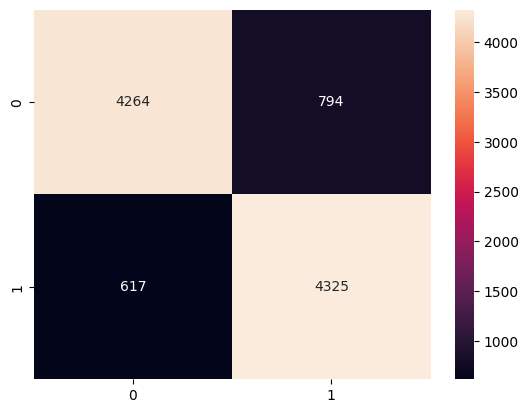

In [ ]:

def show_result(dataloader, model, trainer):
    test_loader = dataloader.test_dataloader()

    predictions_ = trainer.predict(model, test_loader)
    all_max_indices = torch.tensor([])

    for i in predictions_:
        all_max_indices = torch.concat([all_max_indices,i['y_pred']])


    y_true = np.array([data[1] for data in iter(test_loader.dataset)])
    y_pred = all_max_indices

    print('CLASSIFICATION REPORT \n',classification_report(y_true, y_pred))
    print(f'-'*50)
    cm = confusion_matrix(y_true, y_pred)
    print('CONFUSION MATRIX \n')
    sns.heatmap(cm, annot=True, fmt='g')

show_result(dataloader, model, trainer)

*

# Embedding 100D + BiGRU

In [ ]:
# seed_everything(42, workers = True)


early_stopping = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    stopping_threshold=1e-5
)

# BiLSTM
model1 = LitLSTM(
    hidden_size = 64,
    num_classes = 2,
    embedding = embedding_matrix,
    mode = 'gru'
)

dataloader = DataLoader(batch_size=256)
trainer1 = Trainer(
    accelerator='gpu',
    max_epochs = 100,
    callbacks = [early_stoppingl],
)

trainer1.fit(model1, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 45.5 M
1 | rnn       | GRU              | 140 K 
2 | model     | Sequential       | 130   
3 | loss      | CrossEntropyLoss | 0     
4 | f1        | BinaryF1Score    | 0     
5 | recall    | BinaryRecall     | 0     
6 | precision | BinaryPrecision  | 0     
-----------------------------------------------
45.6 M    Trainable params
0         Non-trainable params
45.6 M    Total params
182.556   Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(trainer1.test(ckpt_path = 'best', datamodule = dataloader))

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_8/checkpoints/epoch=5-step=708.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_8/checkpoints/epoch=5-step=708.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.8521983623504639     │
│         test_loss         │    0.6302775144577026     │
│      test_precision       │    0.8330714106559753     │
│        test_recall        │    0.8734493851661682     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6302775144577026, 'test_f1': 0.8521983623504639, 'test_recall': 0.8734493851661682, 'test_precision': 0.8330714106559753}]


# Embedding 200D + BiLSTM

In [ ]:
#  Import Glove embedding

embeddings_dictionary = dict()

# Import Glove dim
glove200_file = open('/content/glove.6B.200d.txt', encoding="utf8")

for line in glove200_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove200_file.close()

In [ ]:
# Prepare the embedding for lstm model
import torch
embedding_dim = 200
embedding_matrix = torch.zeros((len(word_counter)+1, embedding_dim))

for word, index in word2index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = torch.from_numpy(embedding_vector)

In [ ]:
embedding_matrix, embedding_matrix.shape

(tensor([[ 0.1564, -0.4036, -0.2963,  ..., -0.8240, -0.0343, -0.1640],
         [-0.0521,  0.3885, -0.2903,  ...,  0.1799, -0.0425,  0.1506],
         [-0.0924,  0.7109, -0.2214,  ..., -0.2326, -0.2620,  0.2551],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 torch.Size([151661, 200]))

In [ ]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    stopping_threshold=1e-5
)

# BiLSTM
model2 = LitLSTM(
    hidden_size = 64,
    num_classes = 2,
    embedding = embedding_matrix
)

dataloader = DataLoader(batch_size=256)
trainer2 = Trainer(
    accelerator='gpu',
    max_epochs = 100,
    callbacks = [early_stopping],
)

trainer2.fit(model2, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 30.3 M
1 | rnn       | LSTM             | 136 K 
2 | model     | Sequential       | 130   
3 | loss      | CrossEntropyLoss | 0     
4 | f1        | BinaryF1Score    | 0     
5 | recall    | BinaryRecall     | 0     
6 | precision | BinaryPrecision  | 0     
-----------------------------------------------
30.5 M    Trainable params
0         Non-trainable params
30.5 M    Total params
121.874   Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(trainer2.test(ckpt_path = 'best', datamodule = dataloader))

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=6-step=826.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=6-step=826.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.8581563234329224     │
│         test_loss         │    0.5102141499519348     │
│      test_precision       │     0.894034743309021     │
│        test_recall        │    0.8259017467498779     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5102141499519348, 'test_f1': 0.8581563234329224, 'test_recall': 0.8259017467498779, 'test_precision': 0.894034743309021}]


# Embedding 200D + BiGRU

In [ ]:
# seed_everything(42, workers = True)


early_stopping = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    stopping_threshold=1e-5
)

# BiLSTM
model3 = LitLSTM(
    hidden_size = 64,
    num_classes = 2,
    embedding = embedding_matrix,
    mode = 'gru'
)

dataloader = DataLoader(batch_size=256)

trainer3 = Trainer(
    accelerator='gpu',
    max_epochs = 100,
    callbacks = [early_stopping],
)

trainer3.fit(model3, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 45.5 M
1 | rnn       | GRU              | 140 K 
2 | model     | Sequential       | 130   
3 | loss      | CrossEntropyLoss | 0     
4 | f1        | BinaryF1Score    | 0     
5 | recall    | BinaryRecall     | 0     
6 | precision | BinaryPrecision  | 0     
-----------------------------------------------
45.6 M    Trainable params
0         Non-trainable params
45.6 M    Total params
182.556   Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(trainer3.test(ckpt_path = 'best', datamodule = dataloader))

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_11/checkpoints/epoch=5-step=708.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_11/checkpoints/epoch=5-step=708.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │     0.853116512298584     │
│         test_loss         │    0.7098268270492554     │
│      test_precision       │    0.8323839902877808     │
│        test_recall        │    0.8761538863182068     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7098268270492554, 'test_f1': 0.853116512298584, 'test_recall': 0.8761538863182068, 'test_precision': 0.8323839902877808}]


# Embedding 300D + BiLSTM

In [ ]:
#  Import Glove embedding

embeddings_dictionary = dict()

# Import Glove dim
glove300_file = open('/content/glove.6B.300d.txt', encoding="utf8")

for line in glove300_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove300_file.close()

In [ ]:
# Prepare the embedding for lstm model
import torch
embedding_dim = 300
embedding_matrix = torch.zeros((len(word_counter)+1, embedding_dim))

for word, index in word2index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = torch.from_numpy(embedding_vector)

In [ ]:
embedding_matrix, embedding_matrix.shape

(tensor([[ 0.3007, -0.4687, -0.2062,  ...,  0.4927, -0.1128, -0.2777],
         [-0.3676,  0.3950, -0.2703,  ..., -0.3725, -0.3899,  0.0315],
         [ 0.6884,  0.4187, -0.0218,  ...,  0.2445,  0.1004, -0.4107],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 torch.Size([151661, 300]))

In [ ]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    stopping_threshold=1e-5
)

# BiLSTM
model4 = LitLSTM(
    hidden_size = 64,
    num_classes = 2,
    embedding = embedding_matrix
)

dataloader = DataLoader(batch_size=256)
trainer4 = Trainer(
    accelerator='gpu',
    max_epochs = 100,
    callbacks = [early_stopping],
)

trainer4.fit(model4, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 45.5 M
1 | rnn       | LSTM             | 187 K 
2 | model     | Sequential       | 130   
3 | loss      | CrossEntropyLoss | 0     
4 | f1        | BinaryF1Score    | 0     
5 | recall    | BinaryRecall     | 0     
6 | precision | BinaryPrecision  | 0     
-----------------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.743   Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(trainer4.test(ckpt_path = 'best', datamodule = dataloader))

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_6/checkpoints/epoch=5-step=708.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_6/checkpoints/epoch=5-step=708.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.8380682468414307     │
│         test_loss         │    0.5053516626358032     │
│      test_precision       │     0.895825207233429     │
│        test_recall        │    0.7885399460792542     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5053516626358032, 'test_f1': 0.8380682468414307, 'test_recall': 0.7885399460792542, 'test_precision': 0.895825207233429}]


# Embedding 300D + BiGRU

In [ ]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    stopping_threshold=1e-5
)

# BiLSTM
model5 = LitLSTM(
    hidden_size = 64,
    num_classes = 2,
    embedding = embedding_matrix,
    mode = 'gru'
)

dataloader = DataLoader(batch_size=256)
trainer5 = Trainer(
    accelerator='gpu',
    max_epochs = 100,
    callbacks = [early_stopping],
)

trainer5.fit(model5, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 45.5 M
1 | rnn       | GRU              | 140 K 
2 | model     | Sequential       | 130   
3 | loss      | CrossEntropyLoss | 0     
4 | f1        | BinaryF1Score    | 0     
5 | recall    | BinaryRecall     | 0     
6 | precision | BinaryPrecision  | 0     
-----------------------------------------------
45.6 M    Trainable params
0         Non-trainable params
45.6 M    Total params
182.556   Total estimated model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(trainer5.test(ckpt_path = 'best', datamodule = dataloader))

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_12/checkpoints/epoch=5-step=708.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_12/checkpoints/epoch=5-step=708.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.8466860055923462     │
│         test_loss         │    0.6635653376579285     │
│      test_precision       │    0.8818284273147583     │
│        test_recall        │    0.8151184916496277     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6635653376579285, 'test_f1': 0.8466860055923462, 'test_recall': 0.8151184916496277, 'test_precision': 0.8818284273147583}]
